# Customer Service Chatbot - In-Context Learning Chatbot using Llama Index and Language Model API (OpenAI, Hugging Face)

## I. Import Libraries

In [59]:
import numpy as np
import pandas as pd
from llama_index import ServiceContext, SimpleDirectoryReader, GPTVectorStoreIndex, LLMPredictor, PromptHelper, VectorStoreIndex, KeywordTableIndex, StorageContext, load_index_from_storage
from langchain import OpenAI
import os
from IPython.display import Markdown, display
import openai
import time
import nltk
from ratelimit import limits, RateLimitException
import gradio as gr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## II. Load and Clean Data

In this project, we will work with the Customer Support on Twitter dataset, which is is a large, modern corpus of tweets and replies to aid innovation in natural language understanding and conversational models, and for study of modern customer support practices and impact.

https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter/data

The dataset contains customer serivce conversation from many companies as below: 

![Data_sumary](./Image/Datasetsummary.png)

### II.1. Load data

In [3]:
# Load data
df_raw = pd.read_csv('./data/twcs.csv')
df_raw

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
1048570,1160526,122264,True,Tue Oct 24 16:30:49 +0000 2017,When @Morrisons does you good 🙌 https://t.co/6...,"116,052,511,605,271,000,000",NaN
1048571,1160529,Morrisons,False,Tue Oct 24 16:40:49 +0000 2017,@393038 ... Along with your More card and addr...,NaN,1160530.0
1048572,1160530,393038,True,Tue Oct 24 16:04:48 +0000 2017,@Morrisons https://t.co/mnGeW3E7N8,1160529,1160531.0
1048573,1160531,393038,True,Tue Oct 24 16:04:13 +0000 2017,"@Morrisons watford, bought crayfish tails the ...","11,605,301,160,532",NaN


### II.2. Clean data

In [4]:
# Extract "brand" from text 
df_raw['brand'] = df_raw['text'].str.extract(r'@(\w+) ')

In [5]:
# Display data
df_raw.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,brand
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,115712
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,115712
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,sprintcare


In [8]:
# Count brand
df_raw['brand'].value_counts().head(20)

AmazonHelp         59669
AppleSupport       27625
AmericanAir        16556
Uber_Support       15866
Delta              14413
VirginTrains       12164
British_Airways    11295
SpotifyCares       10106
SouthwestAir        9981
XboxSupport         9805
Tesco               9529
AskPlayStation      9457
GWRHelp             8392
hulu_support        7684
115850              7516
ChipotleTweets      7300
sainsburys          7074
Safaricom_Care      6792
VerizonSupport      6541
115858              6511
Name: brand, dtype: int64

Since I want to work with medium size data, I chose `Verizon` to proceed further.

In [9]:
# Keep only tweets from Verizon
df_filtered = df_raw[df_raw['brand'] == 'VerizonSupport']

In [10]:
# Display data
df_filtered

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,brand
29,35,115719,True,Tue Oct 31 22:49:16 +0000 2017,@VerizonSupport I finally got someone that hel...,37,34.0,VerizonSupport
31,36,115719,True,Tue Oct 31 22:10:46 +0000 2017,somebody from @VerizonSupport please help meee...,34,NaN,VerizonSupport
33,39,115720,True,Tue Oct 31 22:12:16 +0000 2017,@VerizonSupport My friend is without internet ...,38,NaN,VerizonSupport
35,41,115721,True,Tue Oct 31 22:24:55 +0000 2017,@VerizonSupport What else can I provide? They ...,43,40.0,VerizonSupport
37,44,115721,True,Tue Oct 31 22:32:06 +0000 2017,@VerizonSupport How? I have my phone number an...,45,43.0,VerizonSupport
...,...,...,...,...,...,...,...,...
1047976,1159913,392876,True,Sun Oct 15 18:19:29 +0000 2017,@VerizonSupport internet down again in Hampste...,1159912,NaN,VerizonSupport
1048275,1160219,392964,True,Tue Oct 24 16:45:35 +0000 2017,@VerizonSupport Will this stop my number appea...,1160221,1160218.0,VerizonSupport
1048277,1160220,392964,True,Tue Oct 24 16:39:47 +0000 2017,@VerizonSupport can you fix telemarketers spoo...,1160218,NaN,VerizonSupport
1048279,1160223,125005,True,Tue Oct 24 16:40:21 +0000 2017,@VerizonSupport Thank you. Happy Tuesday to yo...,NaN,1160222.0,VerizonSupport


In [11]:
# Keep only necessary columns
df_filtered = df_filtered[['tweet_id','author_id','text','response_tweet_id','in_response_to_tweet_id']]

In [12]:
# Display data
df_filtered

,tweet_id,author_id,text,response_tweet_id,in_response_to_tweet_id
29,35,115719,@VerizonSupport I finally got someone that hel...,37,34.0
31,36,115719,somebody from @VerizonSupport please help meee...,34,NaN
33,39,115720,@VerizonSupport My friend is without internet ...,38,NaN
35,41,115721,@VerizonSupport What else can I provide? They ...,43,40.0
37,44,115721,@VerizonSupport How? I have my phone number an...,45,43.0
...,...,...,...,...,...
1047976,1159913,392876,@VerizonSupport internet down again in Hampste...,1159912,NaN
1048275,1160219,392964,@VerizonSupport Will this stop my number appea...,1160221,1160218.0
1048277,1160220,392964,@VerizonSupport can you fix telemarketers spoo...,1160218,NaN
1048279,1160223,125005,@VerizonSupport Thank you. Happy Tuesday to yo...,NaN,1160222.0


In [14]:
# Check data types
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6541 entries, 29 to 1048284
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 6541 non-null   int64  
 1   author_id                6541 non-null   object 
 2   text                     6541 non-null   object 
 3   response_tweet_id        4794 non-null   object 
 4   in_response_to_tweet_id  5519 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 306.6+ KB


Some columns are at incorrect format such as `author_id`, `response_tweet_id`, and `in_response_to_tweet_id`

**Transform some columns to correct format**

In [16]:
# Author ID from Object to Integer
df_filtered = df_filtered[pd.to_numeric(df_filtered['author_id'], errors='coerce').notnull()]
df_filtered['author_id'] = df_filtered['author_id'].astype(int)

In [19]:
# Convert response_tweet_id to Integer
df_filtered = df_filtered[pd.to_numeric(df_filtered['response_tweet_id'], errors='coerce').notnull()]
# Remove commas and convert to integer
df_filtered['response_tweet_id'] = df_filtered['response_tweet_id'].str.extract('(\d+)').astype(int)

In [21]:
# Convert in_response_to_tweet_id to integer
df_filtered['in_response_to_tweet_id'] = df_filtered['in_response_to_tweet_id'].astype(str)
# Remove commas and convert to integer
df_filtered['in_response_to_tweet_id'] = df_filtered['in_response_to_tweet_id'].str.extract('(\d+)').astype(int)

In [93]:
# Display clean data
df_filtered

,tweet_id,author_id,text,response_tweet_id,in_response_to_tweet_id
29,35,115719,@VerizonSupport I finally got someone that hel...,37,34
35,41,115721,@VerizonSupport What else can I provide? They ...,43,40
37,44,115721,@VerizonSupport How? I have my phone number an...,45,43
45,51,115723,"@VerizonSupport Don’t know, router is downstai...",50,52
47,53,115723,@VerizonSupport Just randomly boots me offline...,52,54
...,...,...,...,...,...
1046220,1156388,392018,@VerizonSupport Residential,1158048,1156387
1047026,1158922,339843,@VerizonSupport Keep passing me back and forth...,1158921,1158923
1047964,1159899,392874,@VerizonSupport https://t.co/0yx39H8np8,1159898,1159900
1047966,1159903,392874,@VerizonSupport they say they aren't but they ...,1159900,1159904


In [23]:
# Group tweet into conversation
df = df_filtered.groupby('response_tweet_id')['text'].agg(lambda x: ' '.join(x)).reset_index()

In [24]:
df

,response_tweet_id,text
0,37,@VerizonSupport I finally got someone that hel...
1,43,@VerizonSupport What else can I provide? They ...
2,45,@VerizonSupport How? I have my phone number an...
3,50,"@VerizonSupport Don’t know, router is downstai..."
4,52,@VerizonSupport Just randomly boots me offline...
...,...,...
3534,1158048,@VerizonSupport Residential
3535,1158921,@VerizonSupport Keep passing me back and forth...
3536,1159898,@VerizonSupport https://t.co/0yx39H8np8
3537,1159900,@VerizonSupport they say they aren't but they ...


In [27]:
# Tokenize the text using nltk
nltk.download('punkt')
df['tokens'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

[nltk_data] Downloading package punkt to /Users/Kirudang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
# Check the token for each conversation
df

,response_tweet_id,text,tokens
0,37,@VerizonSupport I finally got someone that hel...,12
1,43,@VerizonSupport What else can I provide? They ...,21
2,45,@VerizonSupport How? I have my phone number an...,36
3,50,"@VerizonSupport Don’t know, router is downstai...",22
4,52,@VerizonSupport Just randomly boots me offline...,11
...,...,...,...
3534,1158048,@VerizonSupport Residential,3
3535,1158921,@VerizonSupport Keep passing me back and forth...,26
3536,1159898,@VerizonSupport https://t.co/0yx39H8np8,5
3537,1159900,@VerizonSupport they say they aren't but they ...,23


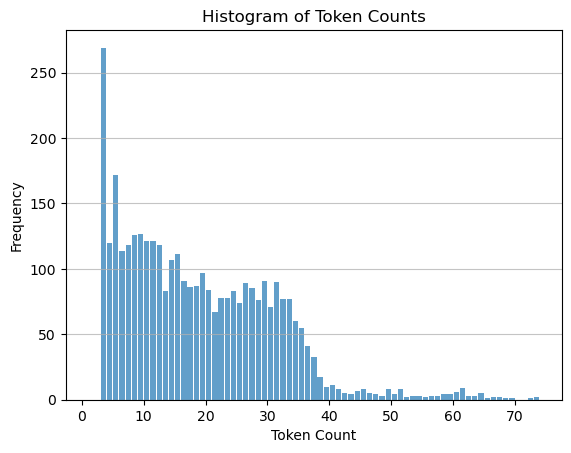

In [32]:
# Plot a histogram of token counts
plt.hist(df['tokens'], bins=range(1, max(df['tokens']) + 2), alpha=0.7, rwidth=0.85)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

As we can see, each conversation only has a small text corpus.

In [44]:
# Join all texts into 1 file
all_text = '\n'.join(df['text'])

In [45]:
# Save text to txt file and save in our directory
f = open("textdata/VerizonSupport.txt", "w") 
f.write(all_text)
f.close()

## III. Build Chatbot Using LLama Index

### 1. Using ChatGPT API

**a. Index Data into Chunks for Easy Callback**

Why we use LLama Index for LLM can be found from this: https://gpt-index.readthedocs.io/en/latest/core_modules/model_modules/llms/usage_custom.html

In [46]:
# Set your API from ChatGPT account
api_key = 'Enter_Your_Key'

In [47]:
# Define the directory path for your data
directory_path = "./textdata"

In [48]:
# Read all data within the folder
documents = SimpleDirectoryReader(directory_path).load_data()

In [55]:
# Define LLM, in this case we use ChatGPT API
llm = OpenAI(openai_api_key=api_key,
             temperature=0, 
             model="gpt-3.5-turbo",
             max_tokens = 256)

In [56]:
# Configure service context
service_context = ServiceContext.from_defaults(
    llm=llm, 
    chunk_size=800, 
    chunk_overlap=20, 
    context_window = 4096, 
    num_output = 256)

In [57]:
# Construct the index to vectorize all the text into chunk index
# IMPORTANT NOTE: ONLY LOAD ONCE, THIS COSTS MONEY
index = VectorStoreIndex.from_documents(documents, 
                                        service_context=service_context)

In [58]:
# Load index result from memory to disk
index.storage_context.persist()

**b. Create a Chatbot**

Query engine can be read from this link: https://gpt-index.readthedocs.io/en/latest/core_modules/query_modules/query_engine/root.html

In [90]:
def chatbot(input_text):
    # Load index from disk
    storage_context = StorageContext.from_defaults(persist_dir="./storage")
    index = load_index_from_storage(storage_context=storage_context)
    # Create a response from input text
    query_engine = index.as_query_engine()
    response = query_engine.query(input_text)
    # Return response
    return response

**c. Create Chatbot UI using Gradio**

For more information, please check its documents here: https://www.gradio.app/docs/interface

In [91]:
iface = gr.Interface(fn=chatbot,
                     inputs=gr.components.Textbox(lines=7, label="Enter your text:"),
                     outputs=gr.components.Textbox(lines=7, label="Answer:"),
                     title=" Your Verizon Support Chatbot")

**Launch the chatbot through App**

In [92]:
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7868

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2023/10/25 00:52:37 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout
